In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, zero_one_loss
from mpl_toolkits.mplot3d import Axes3D

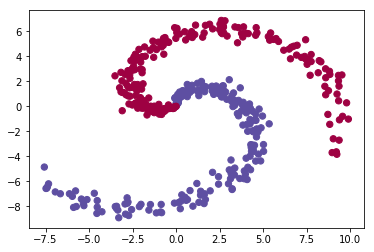

In [3]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes
X = np.zeros((N*K,D))# data matrix (each row = single example)

#Creates targets
y = np.ones(N,dtype=np.int)
minus = -1 * np.ones(N,dtype=np.int)
y = np.append(y,minus)

#Generates the samples
np.random.seed(42)
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,10,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    #y[ix] = j

#Splits data in train/test-sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

#Lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [4]:
# Snodd
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [ ]:
np.shape(X_test)

In [ ]:
# Remove random 25% from each class

a_patterns = X[:round(N), :]

print("a:", np.shape(X))
a_targets = y[:round(N)]

b_patterns = X[round(N):, :]
b_targets = y[round(N):]
print("a:", np.shape(a_targets))
classA_train, classA_test, classA_targets_train, classA_targets_test = train_test_split(a_patterns,a_targets, test_size=0.25)
classB_train, classB_test, classB_targets_train, classB_targets_test = train_test_split(b_patterns,b_targets, test_size=0.25)

X_train = np.concatenate([classA_train, classB_train])
y_train = np.concatenate([classA_targets_train, classB_targets_train])

X_test = np.concatenate([classA_test, classB_test])
y_test = np.concatenate([classA_targets_test, classB_targets_test])

print("x_train:", np.shape(X_test))

In [ ]:
# Remove random 50% from classA

a_patterns = X[:round(N), :]
a_targets = y[:round(N)]

b_patterns = X[round(N):, :]
b_targets = y[round(N):]

classA_train, classA_test, classA_targets_train, classA_targets_test = train_test_split(a_patterns,a_targets, test_size=0.5)

X_train = np.concatenate([classA_train, b_patterns])
y_train = np.concatenate([classA_targets_train, b_targets])

X_test = classA_test.copy()
y_test = classA_targets_test.copy()

X_train, y_train = shuffle_in_unison(X_train, y_train)



In [ ]:
# Remove random 50% from classA

a_patterns = X[:round(N), :]
a_targets = y[:round(N)]

b_patterns = X[round(N):, :]
b_targets = y[round(N):]

classB_train, classB_test, classB_targets_train, classB_targets_test = train_test_split(b_patterns,b_targets, test_size=0.5)

X_train = np.concatenate([classB_train, a_patterns])
y_train = np.concatenate([classB_targets_train, a_targets])

X_test = classB_test.copy()
y_test = classB_targets_test.copy()

X_train, y_train = shuffle_in_unison(X_train, y_train)


In [ ]:
np.shape(X_test)

In [ ]:
# Plot dataset
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(X_train[:, 0], X_train[:,1], c = ["blue"], marker = "o")
#ax.scatter(classB[0, :], classB[1,:], c = ["red"], marker = "o")
ax.set(title='A och B')
#plt.plot(plt.randn(100))
plt.show()

In [5]:
class NeuralNet():
    def __init__(self, inputs, no_nodes1, no_nodes2, eta, epochs):
        self.no_nodes_first_layer = no_nodes1
        self.no_nodes_second_layer = no_nodes2  
        self.no_input_nodes = inputs
        self.eta = eta
        self.epochs = epochs
        self.shape_y = 0
        self.number_of_layers = 2
        
        self.train_zero_losses = []
        self.train_ms_errors = []
        self.test_zero_losses = []
        self.test_ms_errors = []
        
        self.trained_weights = []
        
    def phi_function(self, x):
        return (2 / (1 + np.exp(-x))) - 1
    
    def phi_prime(self, x):
        return (1 + x)*(1 - x) / 2
    
    def init_weights(self, no_inputs, no_neurons):
        #np.random.seed(42)
        return np.random.normal(0, 1, size=(no_inputs + 1, no_neurons))
    
    def examine(self, x):
        w = self.trained_weights[0]
        v = self.trained_weights[1]
        hout,_ = self.forward_pass(v, w, x) 
        return hout[:,:3]
    
    def forward_pass(self, v, w, x):
        bias = np.ones([1, len(x)])
        x = np.column_stack([x, bias.T])
        hin = np.dot(x, w)
        hout = self.phi_function(hin)
        hout = np.column_stack([hout, bias.T])
        
        oin = np.dot(hout, v)
        oout = self.phi_function(oin)
        
        return hout, oout
    
    def backprop(self, v, t, oout, hout):
        t = t.reshape(t.shape[0],self.shape_y)        
        delta_o = np.multiply((oout - t), self.phi_prime(oout))  
        delta_h = np.dot(delta_o, v.T) * self.phi_prime(hout)
        delta_h = delta_h[:, :self.no_nodes_first_layer]
        return delta_h, delta_o
    
    def weight_update(self, x, hout, v, w, dv, dw, delta_h, delta_o):
        alpha = 0.9
        
        bias = np.ones(len(x))
        x = np.column_stack([x, bias.T])
      
        dw = (dw * alpha) - np.array(np.dot(x.T, delta_h)) * (1-alpha)
        dv = (dv * alpha) - np.array(np.dot(hout.T, delta_o)) * (1-alpha)
        
        w = w + dw * self.eta
        v = v + dv * self.eta 
        return (w, v, dw, dv)
      
    def test_accuracy(self, predictions, targets):
        # mean squared error
        mse = mean_squared_error(targets, predictions)
        
        # accuracy
        for i in range(len(predictions)):
            for j in range(len(predictions[i])):
                if predictions[i, j] >= 0:
                    predictions[i, j] = 1
                else:
                    predictions[i, j] = -1
        zero_one = zero_one_loss(targets, predictions, normalize=True)
        
        return mse, zero_one
        
    def batch_learn(self, x_train, y_train, x_test, y_test):
        self.shape_y = int(y_train.size/len(y_train))
        w = self.init_weights(self.no_input_nodes, self.no_nodes_first_layer)
        v = self.init_weights(self.no_nodes_first_layer, self.no_nodes_second_layer)
        dw = 0
        dv = 0
        
        for i in range(self.epochs):
            hout, oout = self.forward_pass(v, w, x_train)
            delta_h, delta_o = self.backprop(v, y_train, oout, hout)

            w, v, dw, dv = self.weight_update(x_train, hout, v, w, dv, dw, delta_h, delta_o)
            
            _, train_predictions = self.forward_pass(v, w, x_train)
            train_mse, train_zero_one = self.test_accuracy(train_predictions, y_train)
            
            _, test_predictions = self.forward_pass(v, w, x_test)
            test_mse, test_zero_one = self.test_accuracy(test_predictions, y_test)
            
            self.train_zero_losses.append(train_zero_one)
            self.train_ms_errors.append(train_mse)
            self.test_zero_losses.append(test_zero_one)
            self.test_ms_errors.append(test_mse)
        self.trained_weights.append(w)
        self.trained_weights.append(v)
            
    def seq_learn(self, x_train, y_train, x_test, y_test):
        w = self.init_weights(self.no_input_nodes, self.no_nodes_first_layer)
        v = self.init_weights(self.no_nodes_first_layer, self.no_nodes_second_layer)
        dw = 0
        dv = 0
        
        for i in range(self.epochs):
            for j in range(len(X_train)):
                x = X_train[j,:]
                x = np.expand_dims(x, axis=1).T
                y = y_train[j]
                
                hout, oout = self.forward_pass(v, w, x)
                delta_h, delta_o = self.backprop(v, y, oout, hout)

                w, v, dw, dv = self.weight_update(x, hout, v, w, dv, dw, delta_h, delta_o)

            _, train_predictions = self.forward_pass(v, w, x_train)
            train_mse, train_zero_one = self.test_accuracy(train_predictions, y_train)
            
            _, test_predictions = self.forward_pass(v, w, x_test)
            test_mse, test_zero_one = self.test_accuracy(test_predictions, y_test)
            
            self.train_zero_losses.append(train_zero_one)
            self.train_ms_errors.append(train_mse)
            self.test_zero_losses.append(test_zero_one)
            self.test_ms_errors.append(test_mse)
            
    def plot_errors(self):
        f,axarr = plt.subplots(2,sharex=True)
        axarr[0].plot(range(self.epochs),self.train_zero_losses, '-',label="train")
        axarr[0].plot(range(self.epochs),self.test_zero_losses, '-',label="test")
        axarr[0].set_title('Ratio of misclassifications')
        
        axarr[1].plot(range(self.epochs),self.train_ms_errors, '-',label="train")
        axarr[1].plot(range(self.epochs),self.test_ms_errors, '-',label="test")
        axarr[1].set_title('Mean squared error')
        
        plt.grid()
        plt.legend()
        plt.show()
        
    def final_errors(self):
        print("Final MSE:", self.test_ms_errors[-1])
        print("Final Zero-One Loss:", self.test_zero_losses[-1])
        
        

In [6]:
a = np.array(X_train[1, :])
a = np.expand_dims(a, axis=1)
np.shape(a)
a

array([[-0.09025196],
       [-0.04421922]])

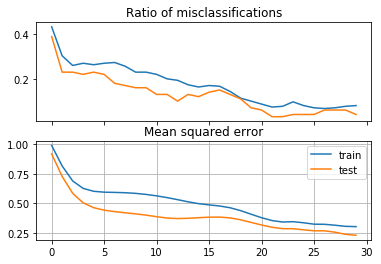

Final MSE: 0.22797561614825795
Final Zero-One Loss: 0.040000000000000036


In [7]:
input_nodes = 2
first_hidden_layer_nodes = 4
second_hidden_layer_nodes = 1
eta = 0.01
epochs = 30

n = NeuralNet(input_nodes, first_hidden_layer_nodes, second_hidden_layer_nodes, eta, epochs)


n.batch_learn(X_train, y_train, X_test, y_test)
n.plot_errors()
n.final_errors()


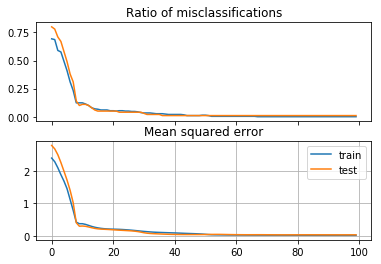

Final MSE: 0.027855660622908448
Final Zero-One Loss: 0.010000000000000009


In [8]:
input_nodes = 2
first_hidden_layer_nodes = 30
second_hidden_layer_nodes = 1
eta = 0.01
epochs = 100

n = NeuralNet(input_nodes, first_hidden_layer_nodes, second_hidden_layer_nodes, eta, epochs)


n.batch_learn(X_train, y_train, X_test, y_test)
n.plot_errors()
n.final_errors()


In [9]:
input_nodes = 2
first_hidden_layer_nodes = 4
second_hidden_layer_nodes = 1
eta = 0.03
epochs = 30

n = NeuralNet(input_nodes, first_hidden_layer_nodes, second_hidden_layer_nodes, eta, epochs)


n.seq_learn(X_train, y_train, X_test, y_test)
n.plot_errors()
n.final_errors()


IndexError: tuple index out of range

In [10]:
#Generates random 1x8 vectors for testing
def generateAutoData(nr):
    #np.random.seed(42)
    X_auto = []
    for i in range(nr):
        index = np.random.randint(8)-1
        one8 = -1*np.ones(8, dtype=int)
        one8[index]=1
        X_auto.append(one8)
    return np.array(X_auto)

#Generates the 8-unique representations of a one-hot-encoded 1x8 vector
def genTrainData():
    X_train=[]
    for i in range(8):
        one8 = -1*np.ones(8, dtype=int)
        one8[i]=1
        X_train.append(one8)
    return np.array(X_train)
        
X_auto_train = genTrainData()
X_auto_test = generateAutoData(50)

#Some examples
print(X_auto_train[0])
print(X_auto_train[1])
print(X_auto_train[2])
print(X_auto_train[3])
print(X_auto_train[7])

[ 1 -1 -1 -1 -1 -1 -1 -1]
[-1  1 -1 -1 -1 -1 -1 -1]
[-1 -1  1 -1 -1 -1 -1 -1]
[-1 -1 -1  1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1  1]


In [ ]:
np.shape(X_auto_test)

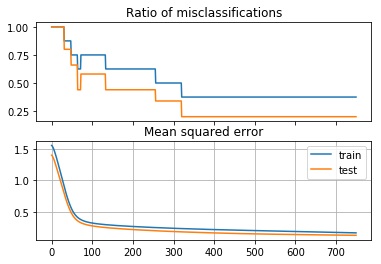

Final MSE: 0.13595987485611336
Final Zero-One Loss: 0.19999999999999996


In [28]:
input_nodes = 8
first_hidden_layer_nodes = 3
second_hidden_layer_nodes = 8
eta = 0.01
epochs = 750

n = NeuralNet(input_nodes, first_hidden_layer_nodes, second_hidden_layer_nodes, eta, epochs)


n.batch_learn(X_auto_train, X_auto_train, X_auto_test, X_auto_test)
n.plot_errors()
n.final_errors()



[ 1 -1 -1 -1 -1 -1 -1 -1]
[ 0.52172407  0.99840506 -0.99797073]

[-1  1 -1 -1 -1 -1 -1 -1]
[ 0.97237823  0.99741061 -0.97698498]

[-1 -1  1 -1 -1 -1 -1 -1]
[-0.96315661  0.99992435 -0.9830379 ]

[-1 -1 -1  1 -1 -1 -1 -1]
[ 0.93543239  0.966752   -0.9731657 ]

[-1 -1 -1 -1  1 -1 -1 -1]
[ 0.10717685  0.95216103 -0.94909516]

[-1 -1 -1 -1 -1  1 -1 -1]
[ 0.97855875  0.98223892 -0.99594396]

[-1 -1 -1 -1 -1 -1  1 -1]
[ 0.97219272  0.9999047  -0.98668778]

[-1 -1 -1 -1 -1 -1 -1  1]
[-0.95486305  0.99974644 -0.99815344]

sign weights: [[-0.10835029 -0.88852318  0.03873674]
 [ 1.44713949 -1.13106477  1.2582507 ]
 [-2.67487239  0.6360974   1.10413961]
 [ 1.01313058 -2.41508521  1.33598461]
 [-0.57946592 -2.60073146  1.66226017]
 [ 1.57534765 -2.09767106  0.38550825]
 [ 1.44374569  0.5206125   0.98207046]
 [-2.57124312  0.03131666 -0.00848586]
 [ 0.91954367  0.96526553 -0.2112181 ]]


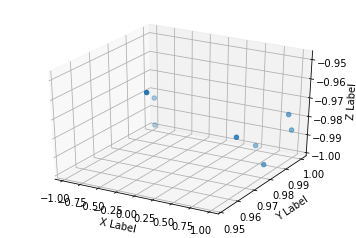

In [18]:
hout = n.examine(X_auto_train)
for i in range(len(X_auto_train)):
    print(X_auto_train[i])
    print(hout[i])
    print()


print("sign weights:", n.trained_weights[0])

fig = plt.figure()
ax5 = fig.add_subplot(111,projection='3d')
#for c,m in [('r','o'),('b','^')]:
ax5.scatter(hout[:,0],hout[:,1],hout[:,2])
    
ax5.set_xlabel('X Label')
ax5.set_ylabel('Y Label')
ax5.set_zlabel('Z Label')
plt.show() 

In [ ]:
1	Results and discussion - Part I: RBF networks and Competitive Learning 